# Recommender Systems: Collaborative Filtering base on MovieLens
## 推荐系统：基于MovieLens的协同过滤

In [67]:
# 加载数据分析常用库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import NMF
from sklearn.neighbors import NearestNeighbors
% matplotlib inline

##设置最大显示的行数和列数
pd.set_option('display.max_columns',20)
pd.set_option('display.max_rows',10)

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [2]:
# 文件下载地址：http://files.grouplens.org/datasets/movielens/ml-20m.zip  
# 注意的是，可以选择小数据样本，同样可以跑通

path = 'ml-20m/'

In [3]:
df_movies=pd.read_csv(path+'movies.csv')
df_links=pd.read_csv(path + 'links.csv')
df_tags=pd.read_csv(path + 'tags.csv')
df_ratings=pd.read_csv(path + 'ratings.csv')
df_genome_scores=pd.read_csv(path + 'genome-scores.csv')
df_genome_tags=pd.read_csv(path + 'genome-tags.csv')

##计算用户总数、电影总数、标签ID总数
users_num=df_ratings.userId.unique().shape[0]
movies_num=df_ratings.movieId.unique().shape[0]
tagIds_num=df_genome_scores.tagId.unique().shape[0]
print(users_num,'users') 
print(movies_num,'movies')  
print(tagIds_num,'tagIds')

138493 users
26744 movies
1128 tagIds


In [4]:
# 需要对movie_id作映射，否则直接用id做矩阵，会太大。
# 由于user_id已经是按照顺序排列的，无需作映射
movie_id_map = pd.DataFrame({'movieId':df_ratings.movieId.unique().tolist(),'movieId_new':[i+1 for i in range(len(df_ratings.movieId.unique()))]})
df_ratings = df_ratings.merge(movie_id_map , on='movieId')

In [7]:
# 数量太大，只取前10000个数据进行试验
df_ratings = df_ratings[df_ratings.userId<10001]
df_ratings = df_ratings[df_ratings.movieId_new<10001]

In [8]:
%%time
#快速构建矩阵，如果尝试最大矩阵，也就是5秒的事情。
ratings_matrix = np.zeros((10000,10000))
ratings_matrix[df_ratings.userId.as_matrix()-1,df_ratings.movieId_new.as_matrix()-1] = df_ratings.rating.as_matrix()

/media/data/jiahaochen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


CPU times: user 92 ms, sys: 184 ms, total: 276 ms
Wall time: 275 ms


In [9]:
ratings_matrix

array([[3.5, 3.5, 3.5, ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 4. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 2.5, ..., 0. , 0. , 0. ],
       [4. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [10]:
%%time
# 计算稀疏度，发现非常稀疏
sparsity = float(len(ratings_matrix.nonzero()[0]))
sparsity /= (ratings_matrix.shape[0] * ratings_matrix.shape[1])
sparsity *= 100
print ('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 1.46%
CPU times: user 1.12 s, sys: 40 ms, total: 1.16 s
Wall time: 1.16 s


In [11]:
# 训练数据随机抹去10个，作为测试集，看推荐结果

def train_test_split_rating(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
#     assert(np.all((train * test) == 0)) 
    return train, test

In [12]:
rating_train,rating_test = train_test_split_rating(ratings_matrix)

# 计算相似度矩阵，用余弦相似度计算

$$ sim(u, u') = cos(\theta{}) = \frac{\textbf{r}_{u} \dot{} \textbf{r}_{u'}}{\| \textbf{r}_{u} \| \| \textbf{r}_{u'} \|} = \sum_{i} \frac{r_{ui}r_{u'i}}{\sqrt{\sum\limits_{i} r_{ui}^2} \sqrt{\sum\limits_{i} r_{u'i}^2} } $$

In [13]:
#普通做法，过慢，不建议
def slow_similarity(ratings, kind='user'):
    if kind == 'user':
        axmax = 0
        axmin = 1
    elif kind == 'item':
        axmax = 1
        axmin = 0
    sim = np.zeros((ratings.shape[axmax], ratings.shape[axmax]))
    for u in xrange(ratings.shape[axmax]):
        for uprime in xrange(ratings.shape[axmax]):
            rui_sqrd = 0.
            ruprimei_sqrd = 0.
            for i in xrange(ratings.shape[axmin]):
                sim[u, uprime] = ratings[u, i] * ratings[uprime, i]
                rui_sqrd += ratings[u, i] ** 2
                ruprimei_sqrd += ratings[uprime, i] ** 2
            sim[u, uprime] /= rui_sqrd * ruprimei_sqrd
    return sim


#快速做法，用矩阵运算，速度飞快。建议可手动推导一下为何可以如此
def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [14]:
%%time
user_similarity = fast_similarity(rating_train, kind='user')
item_similarity = fast_similarity(rating_train, kind='item')
# print item_similarity[:4, :4]

CPU times: user 2min 6s, sys: 31.2 s, total: 2min 37s
Wall time: 10.5 s


In [46]:
def predict_slow_simple(ratings, similarity, kind='user'):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :].dot(ratings[:, j])\
                             /np.sum(np.abs(similarity[i, :]))
        return pred
    elif kind == 'item':
        for i in range(ratings.shape[0]):
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[j, :].dot(ratings[i, :].T)\
                             /np.sum(np.abs(similarity[j, :]))

        return pred

def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [44]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()        # flatten 所有数值提取后返回一个list
    actual = actual[actual.nonzero()].flatten()   # 只找用作测试的10个数据的位置
    return mean_squared_error(pred, actual)

In [48]:
item_prediction = predict_fast_simple(rating_train, item_similarity, kind='item')
user_prediction = predict_fast_simple(rating_train, user_similarity, kind='user')

print ('User-based CF MSE: ' + str(get_mse(user_prediction, rating_test)))
print ('Item-based CF MSE: ' + str(get_mse(item_prediction, rating_test)))

User-based CF MSE: 9.740722403828071
Item-based CF MSE: 13.370883062970314


# Top-k推荐
目的是使用MSE作为衡量值（越低越好）。具体数学公式为：
$$\hat{r}_{ui} = \frac{\sum\limits_{u'} sim(u, u') r_{u'i}}{\sum\limits_{u'}|sim(u, u')|}$$

In [60]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]    # argsort 返回数组升序排序后的index
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [ ]:
pred = predict_topk(rating_train, user_similarity, kind='user', k=40)
print ('Top-k User-based CF MSE: ' + str(get_mse(pred, rating_test)))

pred = predict_topk(rating_train, item_similarity, kind='item', k=40)
print ('Top-k Item-based CF MSE: ' + str(get_mse(pred, rating_test)))

Top-k User-based CF MSE: 7.817301842261892


In [66]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

for k in tqdm(k_array):
    user_pred = predict_topk(rating_train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(rating_train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, rating_train)]
    user_test_mse += [get_mse(user_pred, rating_test)]
    
    item_train_mse += [get_mse(item_pred, rating_train)]
    item_test_mse += [get_mse(item_pred, rating_test)]  

100%|██████████| 6/6 [3:54:48<00:00, 2348.01s/it]  


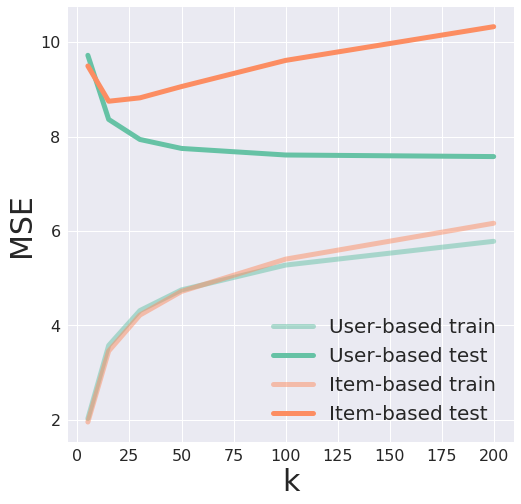

In [69]:
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

# 以下目的是为了减少bias（偏差）
$$\hat{r}_{ui} = \bar{r_{u}} + \frac{\sum\limits_{u'} sim(u, u') (r_{u'i} - \bar{r_{u'}})}{\sum\limits_{u'}|sim(u, u')|}$$

In [70]:
# 减少bias，能有效降低item间推荐误差
def predict_nobias(ratings, similarity, kind='user'):
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
        pred += user_bias[:, np.newaxis]
    elif kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred += item_bias[np.newaxis, :]
        
    return pred

In [71]:
# item-item的MSE明显减少，所以减少bias是游泳的

user_pred = predict_nobias(rating_train, user_similarity, kind='user')
print ('Bias-subtracted User-based CF MSE: ' + str(get_mse(user_pred, rating_test)))

item_pred = predict_nobias(rating_train, item_similarity, kind='item')
print ('Bias-subtracted Item-based CF MSE: ' + str(get_mse(item_pred, rating_test)))

Bias-subtracted User-based CF MSE: 9.857121381671485
Bias-subtracted Item-based CF MSE: 11.237666277126067


In [72]:
def predict_topk_nobias(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
        pred += user_bias[:, np.newaxis]
    if kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items])) 
        pred += item_bias[np.newaxis, :]
        
    return pred

In [73]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

for k in tqdm(k_array):
    user_pred = predict_topk_nobias(rating_train, user_similarity, kind='user', k=k)
    item_pred = predict_topk_nobias(rating_train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, rating_train)]
    user_test_mse += [get_mse(user_pred, rating_test)]
    
    item_train_mse += [get_mse(item_pred, rating_train)]
    item_test_mse += [get_mse(item_pred, rating_test)]  

100%|██████████| 6/6 [3:46:02<00:00, 2260.46s/it]  


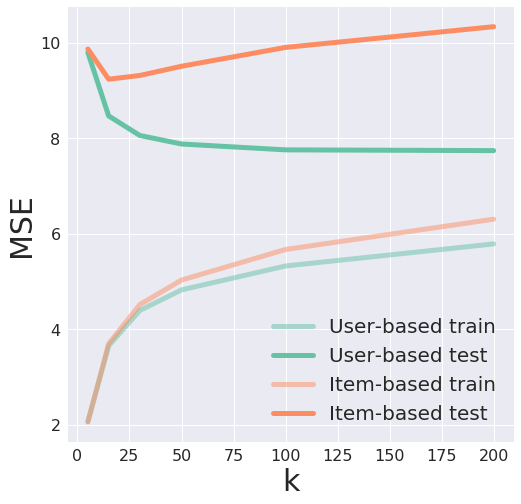

In [74]:
pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);